#CS313.M21: KHAI THÁC DỮ LIỆU VÀ ỨNG DỤNG

###**Chủ đề:** Blockdataset - Cryptocurrency Historical Prices

- GVHD: Ths. Nguyễn Thị Anh Thư
- Sinh viên: 
  1. Trương Thế Tấn - 19522180
  2. Nông Thanh Hồng - 19521551
  3. Nguyễn Thị Hiền Trang - 19522383
  4. Lê Võ Ngọc Anh - 18520452
  5. Nguyễn Hữu Trường - 18521564

###**Nội dung Demo:**
Thực hiện dự đoán giá đóng cửa của một đồng tiền ảo vào ngày sau.
1. Phương pháp 1: Sử dụng các feature: High, Low, Open, Close → Demo với các thuật toán SVR, LassoCV regression, Linear Regression
2. Phương pháp 2: Sử dụng các feature: High. Low, Open, Close, Marketcap → Demo với các thuật toán LassoCV regression, Linear Regression
3. Phương pháp 2: Sử dụng các feature: High. Low, Open, Close, Marketcap. Các feature được chuẩn hóa min-max → Demo với các thuật toán SVR, LassoCV regression, Linear Regression


#Thư viện cần thiết

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import arange
from time import time
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import pathlib
import glob
import re
import joblib
from time import process_time
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LassoCV, Lasso

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#I. Xử lý dữ liệu

## 1.Tải dữ liệu

Đọc dữ liệu lần lượt của 23 đồng tiền ảo trong tập dữ liệu

In [3]:
df = {}

# Đọc dữ liệu
for filename in (glob.glob("/content/drive/MyDrive/1-UIT/CS313-KTDL&UD/Đồ án/data/*.csv")):
  matches = re.findall(r"/coin_([a-zA-Z]*)", filename)
  if matches:
    df[matches[0]] = pd.read_csv(filename)

In [4]:
# copy dữ dữ liệu gốc
df_coin = df.copy()

In [5]:
df_coin['Bitcoin'].head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


## 2.Chuẩn bị dữ liệu để đào tạo và thử nghiệm

Số record của mỗi tệp tiền ảo

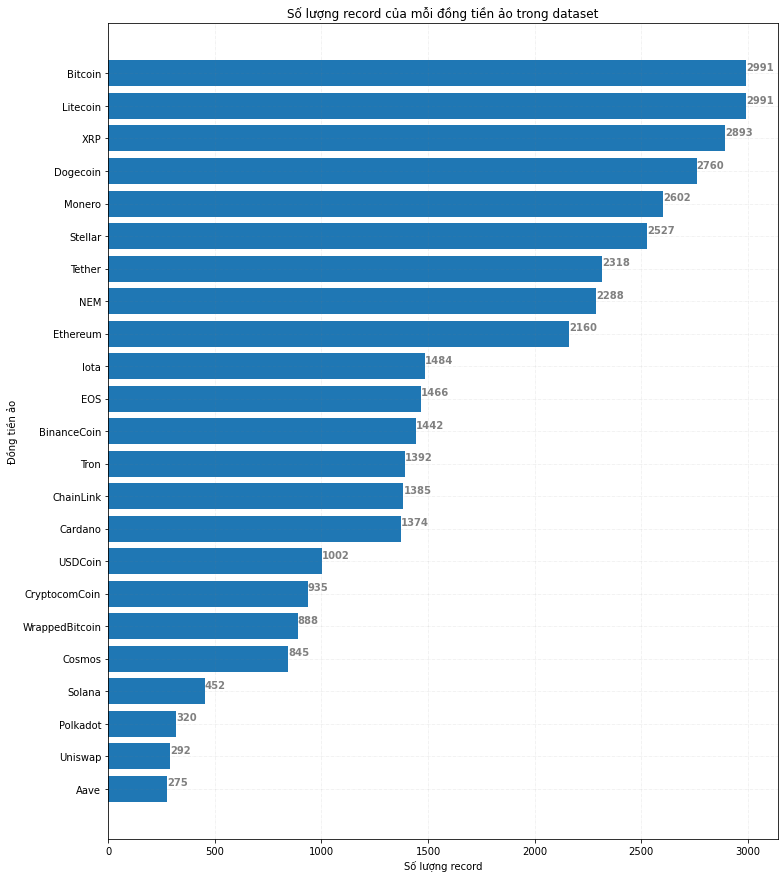

In [6]:
d = {}
for i in df_coin:
  d[i] = df_coin[i].shape[0]

d = dict(sorted(d.items(), key=lambda item: item[1]))

courses = list(d.keys())
values = list(d.values())
  
fig, ax = plt.subplots(figsize =(12, 15))
 
# creating the bar plot
ax.barh(courses, values)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.xlabel("Số lượng record")
plt.ylabel("Đồng tiền ảo")
plt.title("Số lượng record của mỗi đồng tiền ảo trong dataset")
plt.show()

Trực quan hóa dữ liệu với các cột High, Low, Open, Close, Volume, Marketcap

Coin name: Solana, start date: 2020-04-11 23:59:59
High ∈ [0.55975856915, 58.30292665]
Low ∈ [0.505193636791, 46.18755746]
Open ∈ [0.513390527877, 56.08925681]
Close ∈ [0.515272785293, 55.91096029]
Volume ∈ [652020.104651764, 2772224998.89]
Marketcap ∈ [0.0, 15243420387.39]


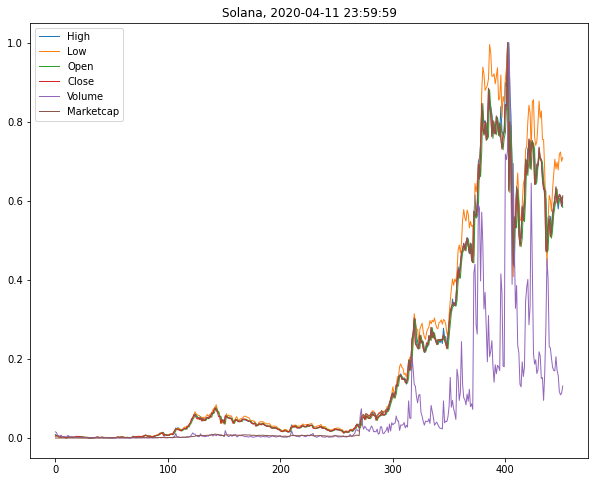


Coin name: USDCoin, start date: 2018-10-09 23:59:59
High ∈ [1.00008227, 1.11373]
Low ∈ [0.929221745866, 1.02305788956]
Open ∈ [0.967938309644, 1.04362709211]
Close ∈ [0.970123943883, 1.04402915715]
Volume ∈ [108803.0, 8053431252.98]
Marketcap ∈ [0.0, 25791977537.21]


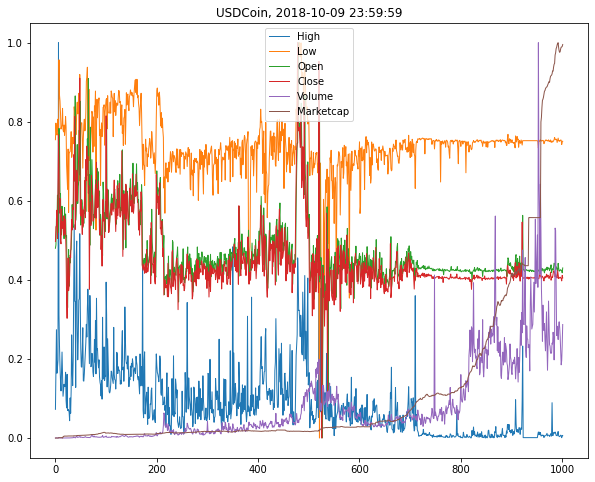


Coin name: Tron, start date: 2017-09-14 23:59:59
High ∈ [0.001830660039559, 0.3003630042076111]
Low ∈ [0.001091259997338, 0.1767120063304901]
Open ∈ [0.0014192200032994, 0.2244990020990371]
Close ∈ [0.0014268299564719, 0.2205549925565719]
Volume ∈ [26474.80078125, 13973157817.56]
Marketcap ∈ [0.0, 14501092591.4]


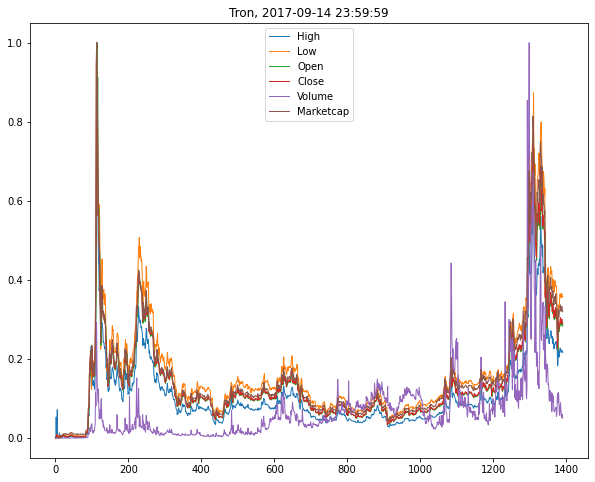


Coin name: Dogecoin, start date: 2013-12-16 23:59:59
High ∈ [8.918750245356932e-05, 0.7375666]
Low ∈ [8.547439938411117e-05, 0.60816772]
Open ∈ [8.715369767742231e-05, 0.68780147]
Close ∈ [8.726520172785968e-05, 0.68477698]
Volume ∈ [0.0, 69410680685.37]
Marketcap ∈ [1509085.15965, 88680824303.07]


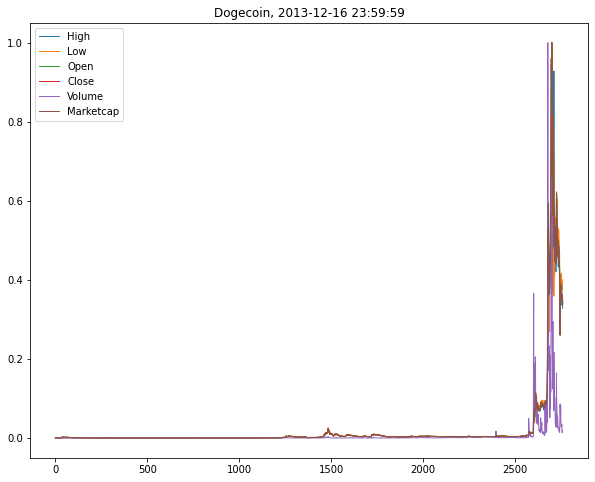


Coin name: BinanceCoin, start date: 2017-07-26 23:59:59
High ∈ [0.1012109965085983, 690.93196468]
Low ∈ [0.0961093977093696, 631.46529812]
Open ∈ [0.0997212007641792, 676.31590539]
Close ∈ [0.0998668000102043, 675.68407747]
Volume ∈ [9284.1904296875, 17982945189.09]
Marketcap ∈ [9986680.0, 103672165463.46]


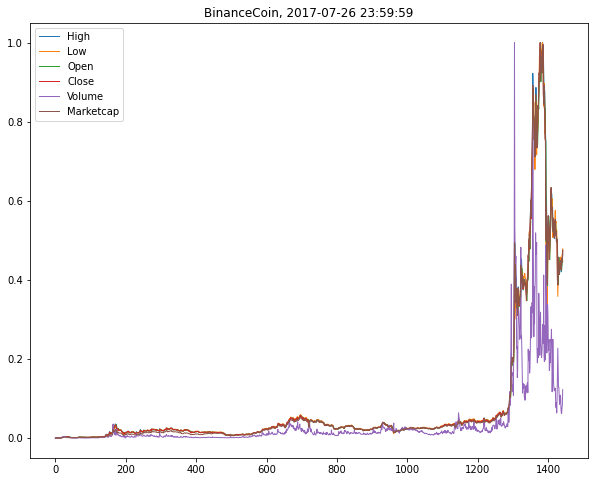


Coin name: Polkadot, start date: 2020-08-21 23:59:59
High ∈ [3.09009266777, 49.69296011]
Low ∈ [2.73091868399, 42.97632297]
Open ∈ [2.87857004326, 47.95978038]
Close ∈ [2.8750282692, 47.94594002]
Volume ∈ [49313136.825242, 10069997171.5]
Marketcap ∈ [0.0, 44973584932.56]


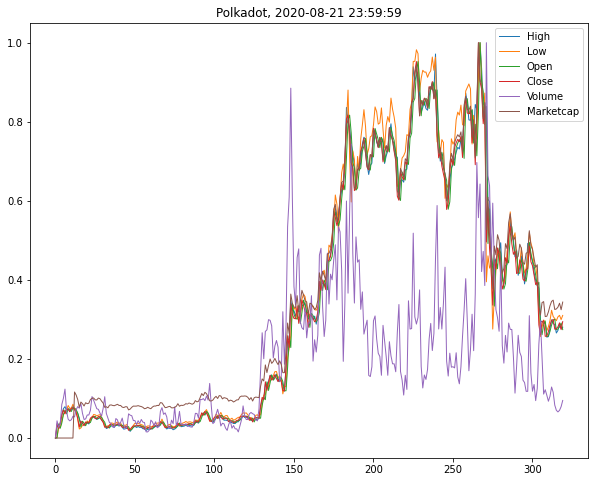


Coin name: ChainLink, start date: 2017-09-21 23:59:59
High ∈ [0.1574400067329406, 52.87608912]
Low ∈ [0.1262969970703125, 46.7292171]
Open ∈ [0.1311099976301193, 52.2476894]
Close ∈ [0.1311289966106414, 52.19869656]
Volume ∈ [398773.0, 170549323809.22]
Marketcap ∈ [45895150.0, 21871752692.13]


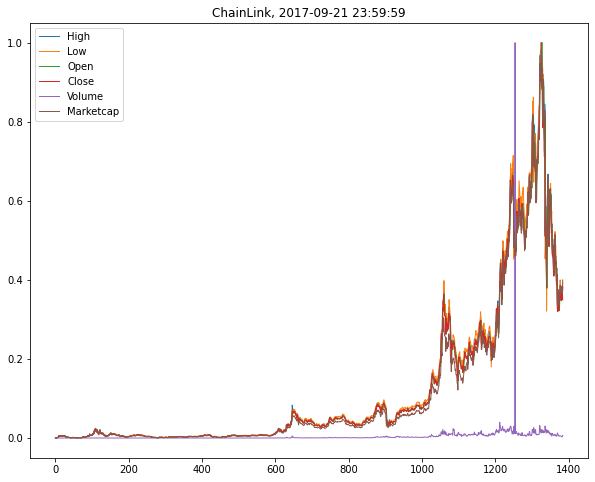


Coin name: Uniswap, start date: 2020-09-18 23:59:59
High ∈ [2.16038741, 44.9740635]
Low ∈ [1.76381655, 41.57613283]
Open ∈ [1.93012344, 43.08332438]
Close ∈ [1.93011859, 43.16450615]
Volume ∈ [189355187.03208768, 6372857509.22218]
Marketcap ∈ [271231751.18131524, 22591622401.48]


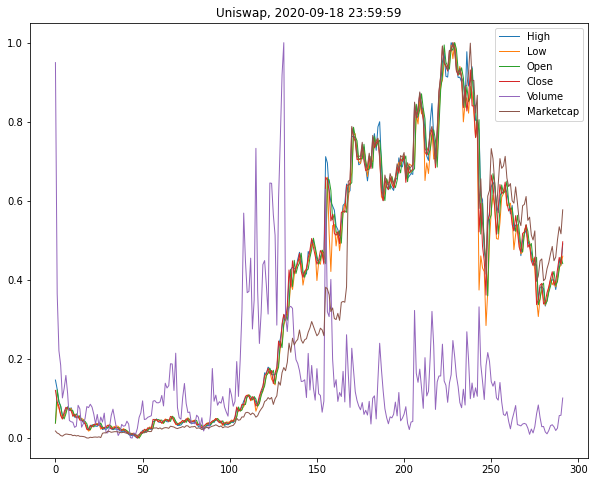


Coin name: WrappedBitcoin, start date: 2019-01-31 23:59:59
High ∈ [3464.20816566, 64796.43545743]
Low ∈ [3330.11634888, 62143.11490961]
Open ∈ [3400.35237427, 63446.93698246]
Close ∈ [3395.9786162, 63436.57977955]
Volume ∈ [67.7519933445204, 921760654.83]
Marketcap ∈ [0.0, 10127848449.3]


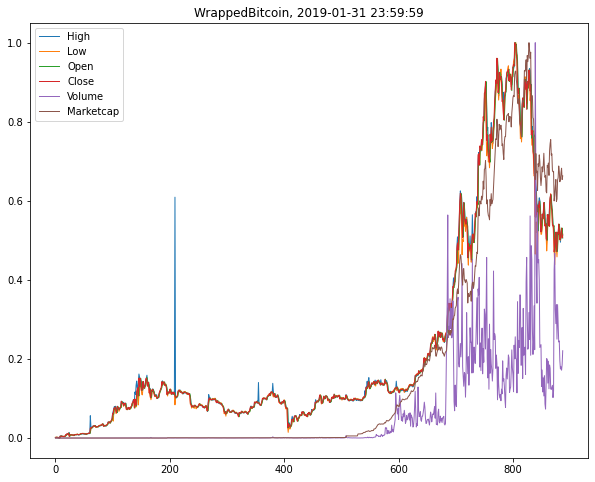


Coin name: CryptocomCoin, start date: 2018-12-15 23:59:59
High ∈ [0.0124633996213, 0.27095969]
Low ∈ [0.0114866815226, 0.23481645]
Open ∈ [0.0121643335745, 0.24641624]
Close ∈ [0.0121327178849, 0.24684827]
Volume ∈ [73880.5142940954, 1993686278.98]
Marketcap ∈ [0.0, 6236131115.2]


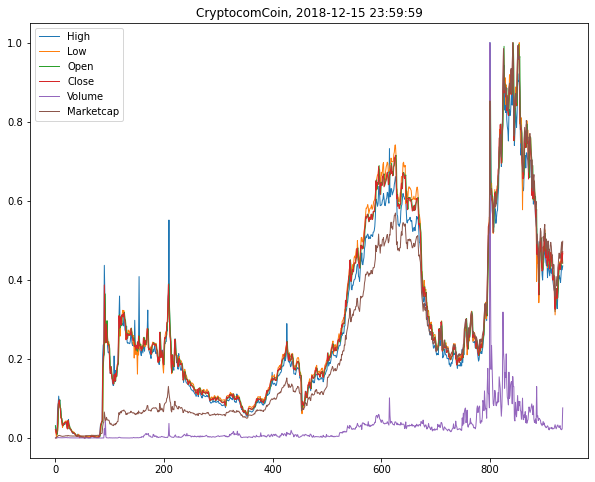


Coin name: Iota, start date: 2017-06-14 23:59:59
High ∈ [0.124736069304, 5.690020084381104]
Low ∈ [0.0796197338733, 4.8613600730896]
Open ∈ [0.110249797996, 5.371049880981445]
Close ∈ [0.110194662118, 5.366330146789551]
Volume ∈ [2334640.0, 2126969984.0]
Marketcap ∈ [306289400.381934, 14915876743.6]


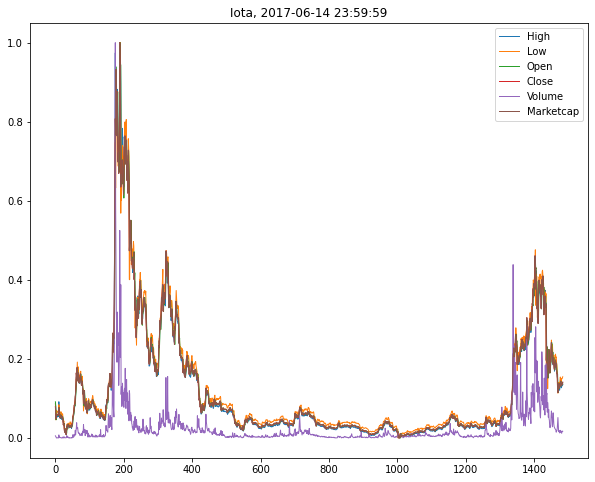


Coin name: EOS, start date: 2017-07-02 23:59:59
High ∈ [0.5186570286750793, 22.890399932861328]
Low ∈ [0.4801959991455078, 18.87739944458008]
Open ∈ [0.492790013551712, 21.63909912109375]
Close ∈ [0.4932250082492828, 21.542600631713867]
Volume ∈ [4556540.0, 20328710731.88]
Marketcap ∈ [0.0, 17769451250.2]


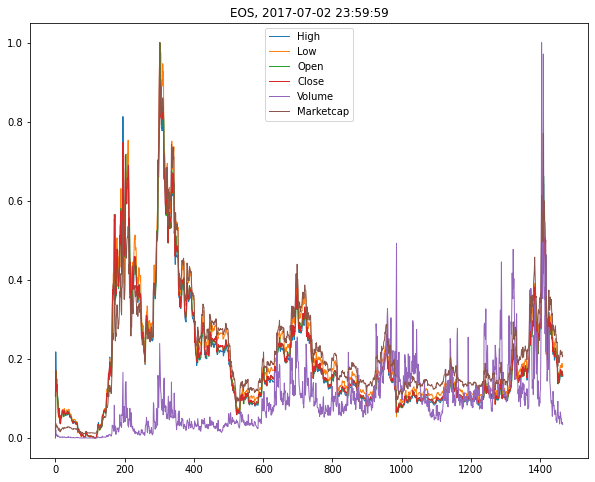


Coin name: Cosmos, start date: 2019-03-15 23:59:59
High ∈ [1.81353406203, 32.13686509]
Low ∈ [1.13096252523, 26.90652617]
Open ∈ [1.65230023468, 29.48237199]
Close ∈ [1.6492031281, 29.43514958]
Volume ∈ [2567200.53305075, 3365947567.78]
Marketcap ∈ [0.0, 6203965905.6]


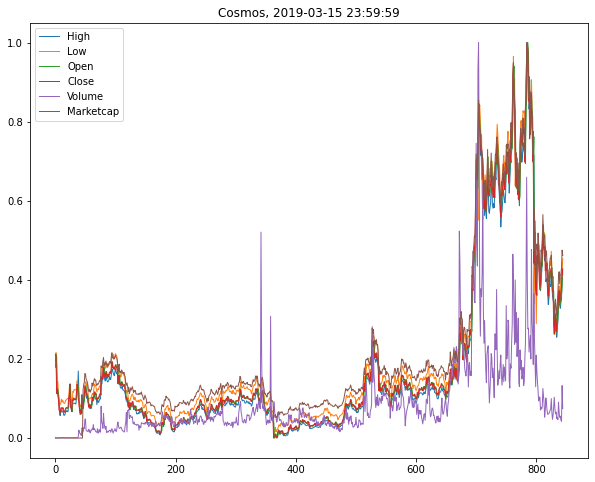


Coin name: Tether, start date: 2015-02-26 23:59:59
High ∈ [0.6062290072441101, 1.2123199701309204]
Low ∈ [0.5683140158653259, 1.1947100162506104]
Open ∈ [0.5712490081787109, 1.21042001247406]
Close ∈ [0.6062290072441101, 1.205739974975586]
Volume ∈ [0.1104969978332519, 279067455600.19]
Marketcap ∈ [152527.2164, 62746499836.1]


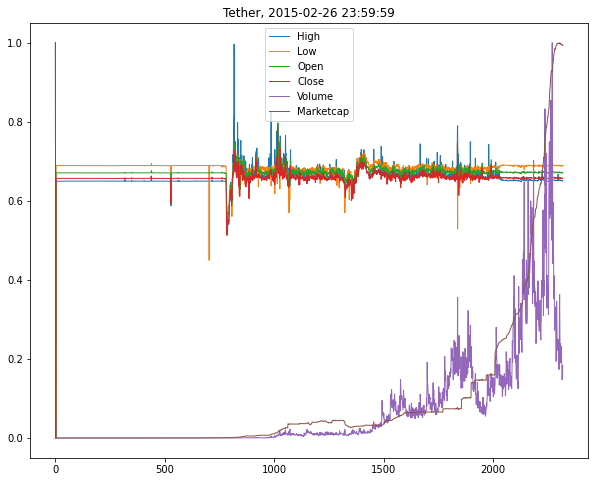


Coin name: NEM, start date: 2015-04-02 23:59:59
High ∈ [8.899070235202089e-05, 2.0918800830841064]
Low ∈ [7.929980347398669e-05, 1.6260199546813965]
Open ∈ [8.570530189899728e-05, 1.8355799913406368]
Close ∈ [8.571510261390358e-05, 1.8427200317382808]
Volume ∈ [69.05079650878906, 8707253548.948313]
Marketcap ∈ [771435.899914, 16584479998.2]


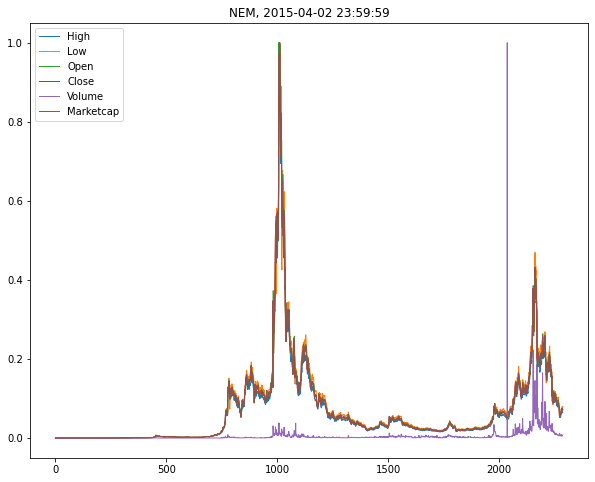


Coin name: Ethereum, start date: 2015-08-08 23:59:59
High ∈ [0.4829879999160766, 4362.3505418]
Low ∈ [0.4208970069885254, 3785.84860304]
Open ∈ [0.4315890073776245, 4174.63587254]
Close ∈ [0.4348289966583252, 4168.70104865]
Volume ∈ [102128.0, 84482912776.49]
Marketcap ∈ [32213626.1748, 482881900490.93]


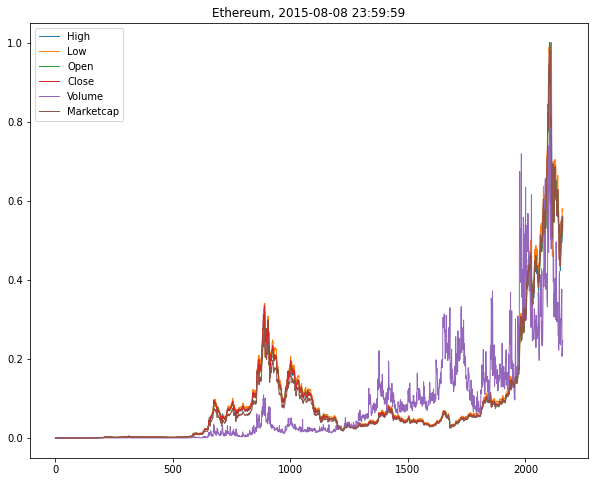


Coin name: Cardano, start date: 2017-10-02 23:59:59
High ∈ [0.0210503004491329, 2.46176633]
Low ∈ [0.0176199991255998, 2.01328507]
Open ∈ [0.0184138994663953, 2.30018996]
Close ∈ [0.0185391008853912, 2.30911258]
Volume ∈ [1739460.0, 19141980288.04]
Marketcap ∈ [480664553.411, 73772243227.06]


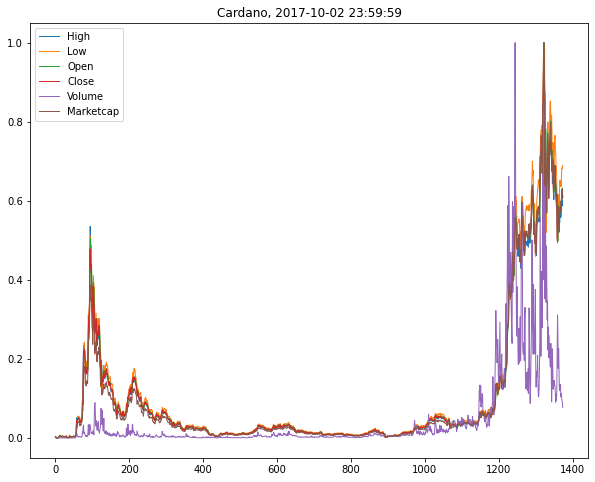


Coin name: Litecoin, start date: 2013-04-29 23:59:59
High ∈ [1.3448100090026855, 412.96014112]
Low ∈ [1.1137399673461914, 345.29883873]
Open ∈ [1.1532399654388428, 387.86917848]
Close ∈ [1.1570099592208862, 386.45077919]
Volume ∈ [0.0, 17994263494.320496]
Marketcap ∈ [37892422.9853, 25796522602.14]


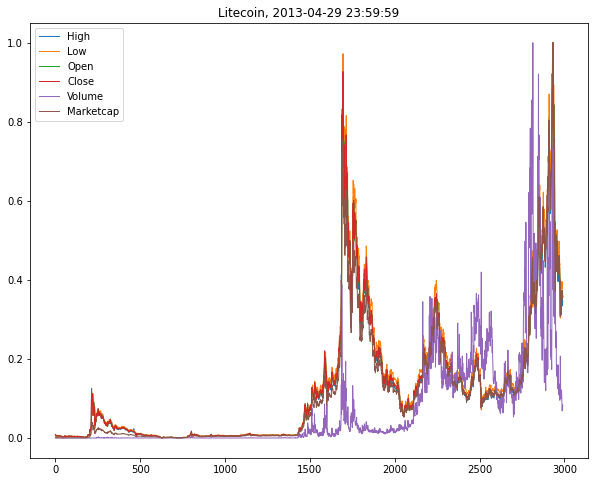


Coin name: Stellar, start date: 2014-08-06 23:59:59
High ∈ [0.0015089899534359, 0.938144028186798]
Low ∈ [0.001227100030519, 0.6774960160255432]
Open ∈ [0.001352300052531, 0.89239901304245]
Close ∈ [0.001356599968858, 0.8962270021438599]
Volume ∈ [491.0920104980469, 10408578426.598703]
Marketcap ∈ [966369.516387, 16854691072.3]


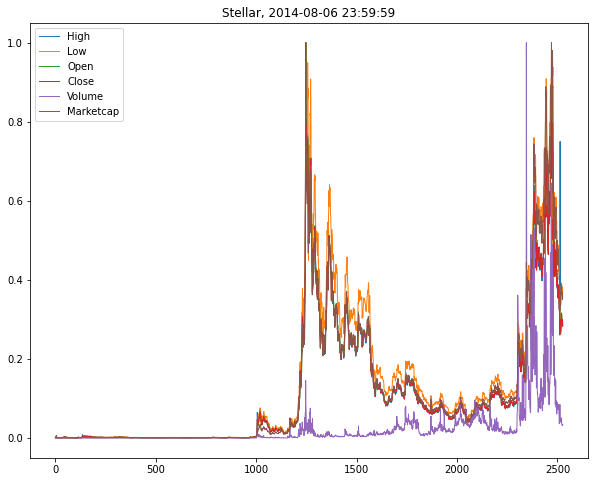


Coin name: Bitcoin, start date: 2013-04-29 23:59:59
High ∈ [74.56109619140625, 64863.0989077]
Low ∈ [65.5260009765625, 62208.96436559]
Open ∈ [68.50499725341797, 63523.75486927]
Close ∈ [68.43099975585938, 63503.45793019]
Volume ∈ [0.0, 350967941479.06]
Marketcap ∈ [778411178.875, 1186364044140.27]


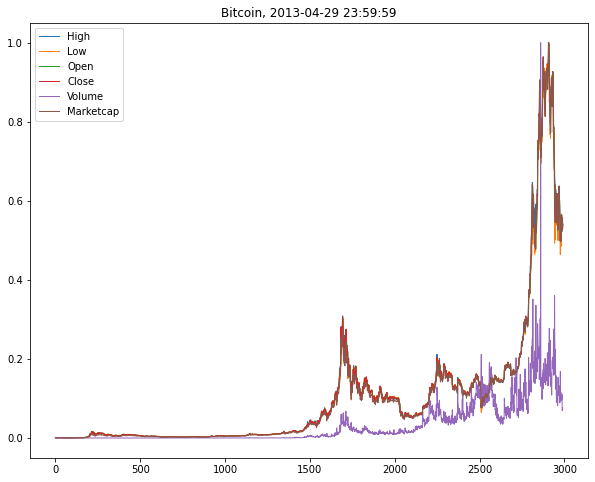


Coin name: Aave, start date: 2020-10-05 23:59:59
High ∈ [28.4330692, 666.86497857]
Low ∈ [25.96615498, 565.74988663]
Open ∈ [27.7150798, 629.2316655]
Close ∈ [27.71508436, 632.26648755]
Volume ∈ [0.0, 2838572595.82]
Marketcap ∈ [67130036.89981823, 8063209781.54]


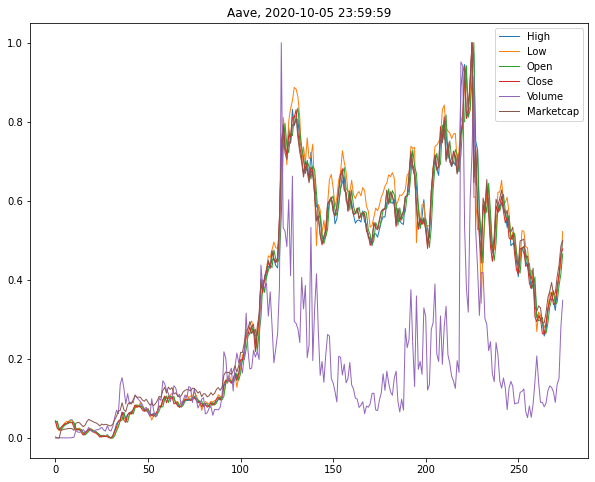


Coin name: Monero, start date: 2014-05-22 23:59:59
High ∈ [0.2517569959163666, 517.62024523]
Low ∈ [0.2129669934511184, 453.3909912109375]
Open ∈ [0.2201209962368011, 483.70997717]
Close ∈ [0.2235219925642013, 483.58361153]
Volume ∈ [7899.56982421875, 28959121742.041]
Marketcap ∈ [1279605.71485, 8658968281.96]


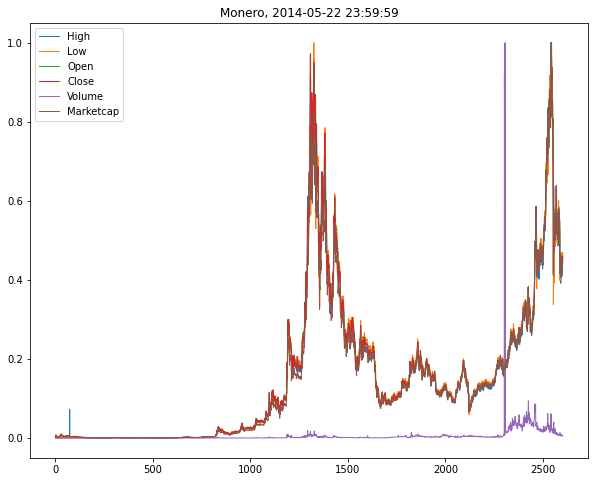


Coin name: XRP, start date: 2013-08-05 23:59:59
High ∈ [0.0030821999534964, 3.841939926147461]
Low ∈ [0.0028023500926792, 3.117340087890625]
Open ∈ [0.0028089799452573, 3.363569974899292]
Close ∈ [0.0028102099895477, 3.377810001373291]
Volume ∈ [0.0, 36955175104.96]
Marketcap ∈ [21969912.0724, 130853470856.0]


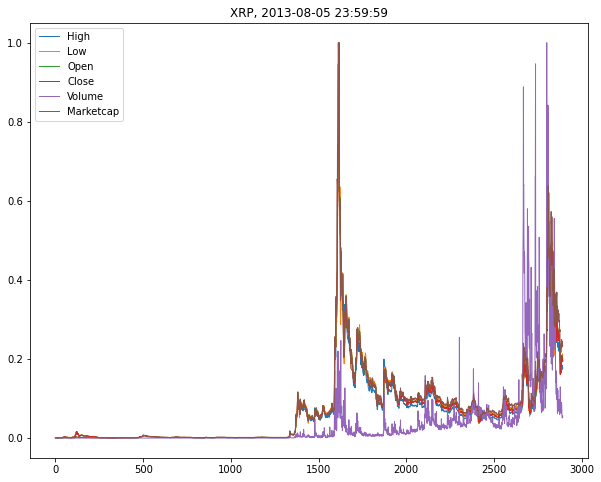

In [7]:
# Hàm chuẩn hóa min-max
def MinMax_Normalization(df):
  min, max = df.min(), df.max()
  return (df-min)/(max-min)

# Trực quan hóa dữ liệu từng loại coins sau khi chuẩn hóa min-max [0, 1]
for index in df_coin:
    plt.figure(figsize=(10,8))
    print('Coin name: {}, start date: {}'.format(index, df_coin[index]['Date'].min()))
    for col in df_coin[index][['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap']]:
      plt.plot(MinMax_Normalization(df_coin[index][col]), label = col, linewidth = 1)
      plt.title('{}, {}'.format(index, df_coin[index]['Date'].min()))
      plt.legend(loc=0)
      print('{} ∈ [{}, {}]'.format(col, df_coin[index][col].min(), df_coin[index][col].max()))

    plt.show()
    print()

Coin name: Bitcoin, start date: 2013-04-29 23:59:59
Coin name: Solana, start date: 2020-04-11 23:59:59
Coin name: Polkadot, start date: 2020-08-21 23:59:59
Coin name: Uniswap, start date: 2020-09-18 23:59:59
Coin name: Ethereum, start date: 2015-08-08 23:59:59
Coin name: Monero, start date: 2014-05-22 23:59:59


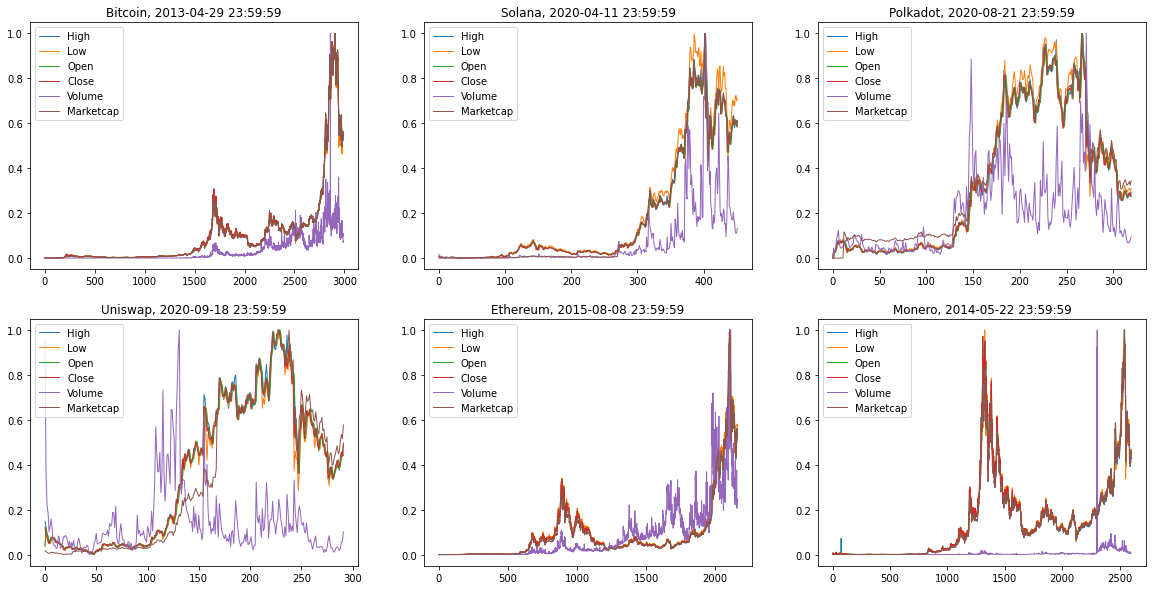

In [8]:
# Trực quan hóa dữ liệu từng loại coins sau khi chuẩn hóa min-max [0, 1]

def plot_feature(index):
  print('Coin name: {}, start date: {}'.format(index, df_coin[index]['Date'].min()))
  for col in df_coin[index][['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap']]:
    ax.plot(MinMax_Normalization(df_coin[index][col]), label = col, linewidth = 1)
    ax.set_title('{}, {}'.format(index, df_coin[index]['Date'].min()))
    ax.legend(loc=0)

i = 0
fig, axs = plt.subplots(nrows=2, ncols=3, constrained_layout=False, figsize=(20,10))
index_name = ['Bitcoin', 'Solana','Polkadot','Uniswap','Ethereum','Monero']
for ax in axs.flat:
  plot_feature(index_name[i])
  i += 1

ta chỉ lấy các cột **Open, High, Low, Volume,  Marketcap, Close** và bỏ các cột **Sno, Name** và **Symboy**.

In [9]:
feature_req = ['High', 'Low', 'Open', 'Marketcap', 'Close']
for i in df_coin:
 df_coin[i] = df_coin[i][feature_req]

In [10]:
# loại các hàng có giá trị bằng 0
for feature in feature_req:
  for i in df_coin:
    df_coin[i] = df_coin[i][df_coin[i][feature] > 0]

In [11]:
df_coin['BinanceCoin'].head()

,High,Low,Open,Marketcap,Close
0,0.109013,0.099266,0.105893,10513800.0,0.105138
1,0.108479,0.100888,0.105108,10773700.0,0.107737
2,0.109019,0.101473,0.107632,10406700.0,0.104067
3,0.111264,0.101108,0.104782,10781100.0,0.107811
4,0.108138,0.103162,0.107935,10641400.0,0.106414


In [12]:
for index in df_coin:
  # Thêm cột giá trị dự đoán = giá USD khi đóng cửa (Close) ngày tiếp theo
  df_coin[index]['Prediction'] = df_coin[index]['Close'].shift(-1)

  # Bỏ hàng cuối vì prediction = NA 
  df_coin[index] = df_coin[index].iloc[:-1]

In [13]:
df_coin['Ethereum'].head()

,High,Low,Open,Marketcap,Close,Prediction
0,2.798810,0.714725,2.793760,4.548689e+07,0.753325,0.701897
1,0.879810,0.629191,0.706136,4.239957e+07,0.701897,0.708448
2,0.729854,0.636546,0.713989,4.281836e+07,0.708448,1.067860
3,1.131410,0.663235,0.708087,6.456929e+07,1.067860,1.217440
4,1.289940,0.883608,1.058750,7.364501e+07,1.217440,1.827670


In [14]:
coin_name = ["Aave", "BinanceCoin", "Bitcoin", "Cardano", "ChainLink", "Cosmos", "CryptocomCoin", "Dogecoin", "EOS", "Ethereum", "Iota", "Litecoin", "Monero", "NEM", "Polkadot", "Solana", "Stellar", "Tether", "Tron", "USDCoin", "Uniswap", "WrappedBitcoin", "XRP"]

# II. Dự đoán



## 1. Dữ liệu demo

In [15]:
BTC_test = []
BTC_test.append(['May 10, 2022',	30273.65,	32596.31,	29944.80,	31022.91,	59811038817,	590565398299])
BTC_test.append(['May 09, 2022',	34060.02,	34222.07,	30296.95,	30296.95,	63355494961,	576716899023])
BTC_test.append(['May 08, 2022',	35502.94,	35502.94,	33878.96,	34059.26,	36763041910,	648302121215])
BTC_test.append(['May 07, 2022',	36042.50,	36129.93,	34940.82,	35501.95,	24375896406,	675729532874])
BTC_test.append(['May 06, 2022',	36573.18,	36624.36,	35482.13,	36040.92,	37795577489,	685953792236])
BTC_test.append(['May 05, 2022',	39695.75,	39789.28,	35856.52,	36575.14,	43106256317,	696088266356])
BTC_test.append(['May 04, 2022',	37748.01,	39902.95,	37732.06,	39698.37,	36754404490,	755491473700])
BTC_test.append(['May 03, 2022',	38528.11,	38629.99,	37585.62,	37750.45,	27326943244,	718385701943])
BTC_test.append(['May 02, 2022',	38472.19,	39074.97,	38156.56,	38529.33,	32922642426,	733170725791])
BTC_test.append(['May 01, 2022',	37713.27,	38627.86,	37585.79,	38469.09,	27002760110,	731986764312])
BTC_test.append(['Apr 30, 2022',	38605.86,	38771.21,	37697.94,	37714.88,	23895713731,	717596901509])
BTC_test.append(['Apr 29, 2022',	39768.62,	39887.27,	38235.54,	38609.82,	30882994649,	734589762490])
BTC_test.append(['Apr 28, 2022',	39241.43,	40269.47,	38941.42,	39773.83,	33903704907,	756698317682])
BTC_test.append(['Apr 27, 2022',	38120.30,	39397.92,	37997.31,	39241.12,	30981015184,	746531438329])
BTC_test.append(['Apr 26, 2022',	40448.42,	40713.89,	37884.99,	38117.46,	34569088416,	725113482674])
BTC_test.append(['Apr 25, 2022',	39472.61,	40491.75,	38338.38,	40458.31,	35445730570,	769607056243])
BTC_test.append(['Apr 24, 2022',	39478.37,	39845.92,	39233.54,	39469.29,	17964398167,	750755023764])
BTC_test.append(['Apr 23, 2022',	39738.72,	39935.86,	39352.20,	39486.73,	16138021249,	751045477435])
BTC_test.append(['Apr 22, 2022',	40525.86,	40777.76,	39315.42,	39740.32,	28011716745,	755827581233])
BTC_test.append(['Apr 21, 2022',	41371.52,	42893.58,	40063.83,	40527.36,	35372786395,	770762297843])
BTC_test.append(['Apr 20, 2022',	41501.74,	42126.30,	40961.10,	41374.38,	27819532341,	786828424699])
BTC_test.append(['Apr 19, 2022',	40828.17,	41672.96,	40618.63,	41502.75,	25303206547,	789227424713])
BTC_test.append(['Apr 18, 2022',	39721.20,	40986.32,	38696.19,	40826.21,	33705182072,	776330593866])
BTC_test.append(['Apr 17, 2022',	40417.78,	40570.73,	39620.89,	39716.95,	19087633042,	755201997823])
BTC_test.append(['Apr 16, 2022',	40552.32,	40633.68,	40078.43,	40424.48,	16833150693,	768615440640])
BTC_test.append(['Apr 15, 2022',	39939.40,	40617.72,	39866.83,	40553.46,	21756855753,	771033872659])
BTC_test.append(['Apr 14, 2022',	41160.22,	41451.48,	39695.74,	39935.52,	24342001973,	759245303311])
BTC_test.append(['Apr 13, 2022',	40123.57,	41430.05,	39712.75,	41166.73,	27691105228,	782617115810])
BTC_test.append(['Apr 12, 2022',	39533.71,	40617.59,	39388.33,	40127.18,	30991500854,	762819737794])
BTC_test.append(['Apr 11, 2022',	42201.04,	42424.59,	39373.06,	39521.90,	33949912166,	751274786459])
BTC_test.append(['Apr 10, 2022',	42781.09,	43376.38,	42021.21,	42207.67,	17654475582,	802293412897])

In [16]:
solana_test = []
solana_test.append(['May 10, 2022',	63.37,	73.76,	61.03,	66.77,	3677013066,	22475117995])
solana_test.append(['May 09, 2022',	75.23,	76.98,	63.27,	63.27,	2773999164,	21297991171])
solana_test.append(['May 08, 2022',	78.99,	79.28,	74.53,	75.22,	1439700868,	25222885523])
solana_test.append(['May 07, 2022',	81.77,	82.18,	77.88,	78.98,	1139093165,	26474257128])
solana_test.append(['May 06, 2022',	84.59,	84.65,	80.47,	81.76,	1585081920,	27365865669])
solana_test.append(['May 05, 2022',	92.77,	95.03,	81.83,	84.60,	1805979399,	28284629324])
solana_test.append(['May 04, 2022',	85.84,	92.94,	85.73,	92.77,	1428455342,	31005535019])
solana_test.append(['May 03, 2022',	87.56,	88.69,	84.92,	85.84,	1011988792,	28689978615])
solana_test.append(['May 02, 2022',	89.67,	90.69,	85.41,	87.58,	1265220129,	29271114446])
solana_test.append(['May 01, 2022',	85.09,	92.43,	84.94,	89.67,	1426749080,	29986417060])
solana_test.append(['Apr 30, 2022',	94.01,	94.93,	82.91,	85.10,	1293033765,	28422718818])
solana_test.append(['Apr 29, 2022',	98.18,	98.57,	92.88,	94.01,	1234575023,	31400352079])
solana_test.append(['Apr 28, 2022',	98.38,	100.40,	96.69,	98.19,	1307131609,	32764948307])
solana_test.append(['Apr 27, 2022',	95.79,	100.54,	95.28,	98.38,	1253566599,	32829333027])
solana_test.append(['Apr 26, 2022',	101.22,	101.74,	95.18,	95.78,	1301074534,	31962849255])
solana_test.append(['Apr 25, 2022',	99.24,	101.44,	94.76,	101.25,	1538486689,	33772914316])
solana_test.append(['Apr 24, 2022',	100.73,	102.22,	99.01,	99.24,	818266008,	33101881731])
solana_test.append(['Apr 23, 2022',	100.62,	102.77,	98.78,	100.74,	823252482,  33605175877])
solana_test.append(['Apr 22, 2022',	101.76,	103.50,	99.58,	100.61,	1274793594,	33561079113])
solana_test.append(['Apr 21, 2022',	105.50,	109.77,	100.77,	101.78,	1838571747,	33935858708])
solana_test.append(['Apr 20, 2022',	108.60,	110.72,	104.77,	105.50,	1761531528,	35176593429])
solana_test.append(['Apr 19, 2022',	102.20,	108.58,	101.30,	108.58,	1711909607,	36205329782])
solana_test.append(['Apr 18, 2022',	100.41,	102.52,	95.24,	102.16,	1846133932,	34030862759])
solana_test.append(['Apr 17, 2022',	102.25,	105.29,	99.96, 100.41,	1057908299,	33448341308])
solana_test.append(['Apr 16, 2022',	101.30,	103.27,	100.96,	102.26,	774939305,	34063156158])
solana_test.append(['Apr 15, 2022',	100.71,	102.67,	100.10,	101.31,	1050639351,	33733487009])
solana_test.append(['Apr 14, 2022',	104.94,	107.33,	99.26,	100.71,	1686576071,	33037638422])
solana_test.append(['Apr 13, 2022',	103.28,	105.68,	100.49,	105.00,	1675840412,	34446417330])
solana_test.append(['Apr 12, 2022',	99.38,	109.12,	98.94,	103.31,	2317008207,	33876639836])
solana_test.append(['Apr 11, 2022',	111.70,	111.83,	98.67,	99.34,	2272498194,	32578478203])
solana_test.append(['Apr 10, 2022',	112.97,	115.81,	110.08,	111.74,	1280232450,	36612845093])

In [17]:
DOT_test = []
DOT_test.append(['May 10, 2022',	10.77,	12.33,	10.45,	11.36,	1771556667,	11217411956])
DOT_test.append(['May 09, 2022',	13.26,	13.46,	10.77,	10.77,	1529550074,	10633301984])
DOT_test.append(['May 08, 2022',	13.77,	13.83,	13.09,	13.25,	758610863,	13089449127])
DOT_test.append(['May 07, 2022',	14.31,	14.35,	13.48,	13.78,	593983001,	13604551349])
DOT_test.append(['May 06, 2022',	14.58,	14.64,	13.94,	14.31,	868156078,	14135323180])
DOT_test.append(['May 05, 2022',	16.30,	16.42,	14.19,	14.58,	953754626,	14399921303])
DOT_test.append(['May 04, 2022',	14.73,	16.31,	14.70,	16.31,	747195893,	16102734247])
DOT_test.append(['May 03, 2022',	14.98,	15.21,	14.56,	14.73,	492425638,	14544117180])
DOT_test.append(['May 02, 2022',	15.38,	15.57,	14.63,	14.98,	684752563,	14792400452])
DOT_test.append(['May 01, 2022',	14.52,	15.51,	14.51,	15.38,	707973556,	15190677415])
DOT_test.append(['Apr 30, 2022',	16.16,	16.41,	14.29,	14.52,	689300174,	14339591541])
DOT_test.append(['Apr 29, 2022',	16.99,	17.05,	16.05,	16.16,	573927609,	15962038041])
DOT_test.append(['Apr 28, 2022',	16.95,	17.36,	16.80,	17.00,	609272520,	16785406016])
DOT_test.append(['Apr 27, 2022',	16.66,	17.25,	16.56,	16.95,	616421238,	16737511425])
DOT_test.append(['Apr 26, 2022',	18.12,	18.30,	16.46,	16.65,	787835544,	16443789087])
DOT_test.append(['Apr 25, 2022',	18.16,	18.22,	17.19,	18.12,	799411358,	17894917102])
DOT_test.append(['Apr 24, 2022',	18.73,	19.14,	18.13,	18.16,	576662878,	17933115345])
DOT_test.append(['Apr 23, 2022',	18.30,	19.23,	18.04,	18.73,	625753368,	18499998573])
DOT_test.append(['Apr 22, 2022',	18.19,	18.52,	18.12,	18.30,	629068408,	18071841212])
DOT_test.append(['Apr 21, 2022',	19.09,	19.63,	18.14,	18.19,	772305840,  17960112940])
DOT_test.append(['Apr 20, 2022',	18.90,	19.49,	18.57,	19.09,	830807797,	18851682495])
DOT_test.append(['Apr 19, 2022',	18.17,	18.93,	18.07,	18.90,	565507514,	18662100179])
DOT_test.append(['Apr 18, 2022',	17.78,	18.31,	17.17,	18.17,	712879608,	17943868855])
DOT_test.append(['Apr 17, 2022',	18.63,	18.80,	17.72,	17.78,	473113233,	17559628612])
DOT_test.append(['Apr 16, 2022',	18.35,	18.68,	18.23,	18.63,	424249982,	18398681106])
DOT_test.append(['Apr 15, 2022',	17.93,	18.38,	17.83,	18.35,	507063069,	18122990185])
DOT_test.append(['Apr 14, 2022',	18.20,	18.47,	17.53,	17.93,	631848192,	17708082150])
DOT_test.append(['Apr 13, 2022',	17.78,	18.27,	17.44,	18.20,	657673530,	17972461925])
DOT_test.append(['Apr 12, 2022',	17.20,	18.00,  17.20,	17.79,	773573439,	17564966530])
DOT_test.append(['Apr 11, 2022',	19.29,	19.29,	17.04,	17.19,	998107923,	16975394025])
DOT_test.append(['Apr 10, 2022',	19.78,	20.20,	19.29,	19.29,	599807810,	19045769298])

In [18]:
col_name = ['Date' , 'Open', 'High', 'Low', 'Close', 'Volume', 'Marketcap']
data = {}
data['Bitcoin'] = BTC_test
data['Solana'] = solana_test
data['Polkadot'] = DOT_test

## 2. Dự đoán kết quả


In [19]:
col_info = ['coin', 'mae_score', 'amape_score', 'time']

In [20]:
def predict_test(filename, df_test_data, features, normalize=False, df_max=None, df_min=None):  
  df_test_data = df_test_data[features]

  if normalize:
    # chuẩn hóa
    df_max = df_test_data.max()
    df_min = df_test_data.min()
    df_test_data = (df_test_data - df_min)/(df_max - df_min)

  # chia X, y
  y = df_test_data.Prediction
  X = df_test_data.iloc[:, :-1]

  # load model
  loaded_model = joblib.load(filename)

  return actual_pred_plot(loaded_model, X, y, normalize, df_max, df_min)

In [21]:
def actual_pred_plot(loaded_model, X, y, normalize=False, df_max=None, df_min=None):
  y_pred = loaded_model.predict(X)

  if normalize:
    # Trả lại tỷ lệ ban đầu theo đơn giá USD cho cột Close
    y = y*(df_max[-1] - df_min[-1]) + df_min[-1]
    y_pred = y_pred*(df_max[-1] - df_min[-1]) + df_min[-1]

  ## Outputs error in United States Dollars
  print ('mean_absolute_error:',mean_absolute_error(y, y_pred))
  print ('mean_absolute_percentage_error:',mean_absolute_percentage_error(y, y_pred))

  plt.figure(dpi = 80)
  plt.plot(y.values, label="Actual Price", color='blue', linewidth =1)
  plt.plot(y_pred.flatten(), label="Predicted Price", color='red', linewidth =1)
  plt.ylabel('Close Price in USD')
  leg = plt.legend()
  plt.show()

  return y_pred, mean_absolute_error(y, y_pred), mean_absolute_percentage_error(y, y_pred)

In [165]:
#name_idx = 'Polkadot'
#name_idx = 'Bitcoin'
name_idx = 'Solana'

test_data = pd.DataFrame(data[name_idx], columns=col_name)

In [166]:
df_test_data = test_data.copy()
df_test_data['Prediction'] = df_test_data['Close'].shift(-1)
df_test_data = df_test_data.iloc[:-1]

df_test_data_compare = test_data.copy()
df_test_data_compare['Price_after_1_day'] = df_test_data_compare['Close'].shift(-1)
df_test_data_compare = df_test_data_compare.iloc[:-1]

In [141]:
y_pred_svr = y_pred_lasso = y_pred_linear = 0

### Phương pháp 1: High-Low-Open-Close
Thuật toán SVR, LassoCV, Linear

In [167]:
lst_mae_1 = []
lst_mape_1 = []
lst_name_idx_1 = []
lst_algo_1 = []
y_pred_svr = y_pred_lasso = y_pred_linear = 0

In [168]:
features = ['High',	'Low', 'Open', 'Close', 'Prediction']

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


mean_absolute_error: 2.2613114357079573
mean_absolute_percentage_error: 0.024917831881378427


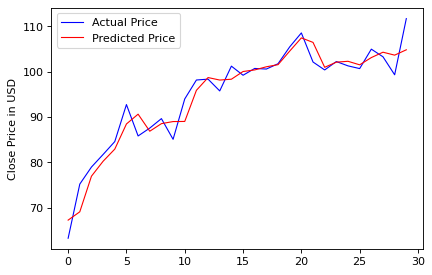

Solana


In [169]:
#SVR 
filename = '/content/drive/MyDrive/1-UIT/CS313-KTDL&UD/Đồ án/Tấn/svr(high-low-open-close)/final/{}.joblib'.format(name_idx)

y_pred_svr, mae, mape = predict_test(filename, df_test_data, features)

print(name_idx)
lst_algo_1.append('SVR')
lst_mae_1.append(mae)
lst_mape_1.append(mape)
lst_name_idx_1.append(name_idx)

mean_absolute_error: 3.4787839797524907
mean_absolute_percentage_error: 0.03735545941154235


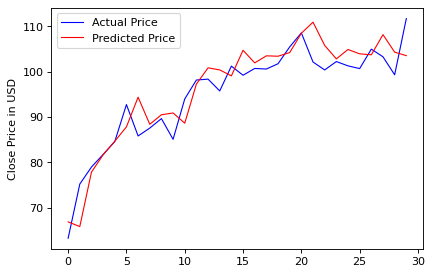

Solana


In [170]:
#Lasso
filename = '/content/drive/MyDrive/1-UIT/CS313-KTDL&UD/Đồ án/Tấn/lasso(high-low-open-close)/{}.sav'.format(name_idx)

y_pred_lasso, mae, mape = predict_test(filename, df_test_data, features)
print (name_idx)
lst_algo_1.append('LassoCV')
lst_mae_1.append(mae)
lst_mape_1.append(mape)
lst_name_idx_1.append(name_idx)

mean_absolute_error: 3.5254481552947032
mean_absolute_percentage_error: 0.037759200579735766


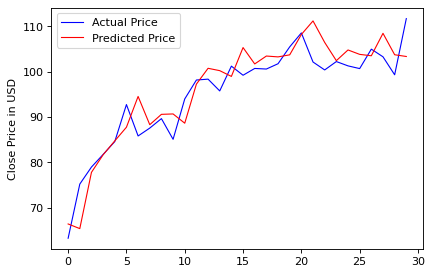

Solana


In [171]:
#Linear
filename = '/content/drive/MyDrive/1-UIT/CS313-KTDL&UD/Đồ án/Tấn/linear(high-low-open-close)/{}.sav'.format(name_idx)

y_pred_linear, mae, mape = predict_test(filename, df_test_data, features)
print (name_idx)
lst_algo_1.append('Linear')
lst_mae_1.append(mae)
lst_mape_1.append(mape)
lst_name_idx_1.append(name_idx)

In [172]:
df_test_data_compare['y_pred_svr'] = y_pred_svr
df_test_data_compare['y_pred_lasso'] = y_pred_lasso
df_test_data_compare['y_pred_linear'] = y_pred_linear

df_test_data_compare.iloc[:, 7:11]

,Price_after_1_day,y_pred_svr,y_pred_lasso,y_pred_linear
0,63.27,67.268158,66.876604,66.420750
1,75.22,69.104895,65.842320,65.395733
2,78.98,76.961865,77.854099,77.808491
3,81.76,80.262402,81.680027,81.690251
4,84.60,82.938128,84.673023,84.749605
5,92.77,88.487811,87.850732,87.773180
6,85.84,90.649143,94.396869,94.562922
7,87.58,86.887332,88.419010,88.331135
8,89.67,88.559102,90.522084,90.611874
9,85.10,89.019627,90.916503,90.699459


In [173]:
record_res_1 = pd.DataFrame({'Algorithm': lst_algo_1,
                           'Data': lst_name_idx_1,
                           'MAE_1': lst_mae_1,
                           'MAPE_1': lst_mape_1})

record_res_1.set_index(['Data', 'Algorithm'])

MAE_1    MAPE_1
Data   Algorithm                    
Solana SVR        2.261311  0.024918
       LassoCV    3.478784  0.037355
       Linear     3.525448  0.037759

###Phương pháp 2: High-Low-Open-Close-Marketcap
Thuật toán LassoCV, Linear

In [174]:
y_pred_svr = y_pred_lasso = y_pred_linear = 0

In [175]:
lst_mae_2 = []
lst_mape_2 = []
lst_name_idx_2 = []
lst_algo_2 = []
y_pred_svr = y_pred_lasso = y_pred_linear = 0

In [176]:
features = ['High',	'Low', 'Open','Marketcap', 'Close', 'Prediction']

In [177]:
#SVR 

print(name_idx)
lst_algo_2.append('SVR')
lst_mae_2.append(-1)
lst_mape_2.append(-1)
lst_name_idx_2.append(name_idx)

Solana


mean_absolute_error: 3.8172019601044562
mean_absolute_percentage_error: 0.04121188459158687


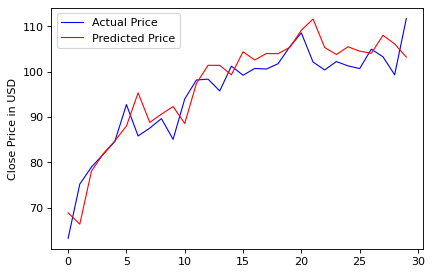

Solana


In [178]:
#Lasso
filename = '/content/drive/MyDrive/1-UIT/CS313-KTDL&UD/Đồ án/Tấn/lasso(high-low-open-close-marketcap)/{}.sav'.format(name_idx)

y_pred_lasso, mae, mape = predict_test(filename, df_test_data, features)
print (name_idx)
lst_algo_2.append('LassoCV')
lst_mae_2.append(mae)
lst_mape_2.append(mape)
lst_name_idx_2.append(name_idx)

mean_absolute_error: 3.420022563397543
mean_absolute_percentage_error: 0.03679599278508006


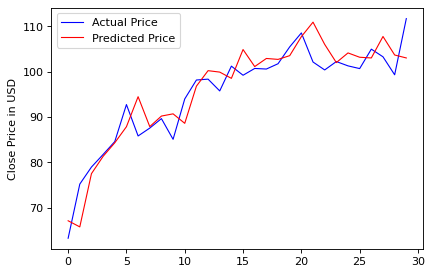

Solana


In [179]:
#Linear
filename = '/content/drive/MyDrive/1-UIT/CS313-KTDL&UD/Đồ án/Tấn/linear(high-low-open-close-marketcap)/{}.sav'.format(name_idx)

y_pred_linear, mae, mape = predict_test(filename, df_test_data, features)
print (name_idx)
lst_algo_2.append('Linear')
lst_mae_2.append(mae)
lst_mape_2.append(mape)
lst_name_idx_2.append(name_idx)

In [180]:
df_test_data_compare['y_pred_svr'] = y_pred_svr
df_test_data_compare['y_pred_lasso'] = y_pred_lasso
df_test_data_compare['y_pred_linear'] = y_pred_linear

df_test_data_compare.iloc[:, 7:11]

,Price_after_1_day,y_pred_svr,y_pred_lasso,y_pred_linear
0,63.27,0,68.873159,67.125298
1,75.22,0,66.386747,65.776694
2,78.98,0,78.076204,77.520047
3,81.76,0,81.878450,81.343973
4,84.60,0,84.730868,84.339255
5,92.77,0,88.036512,87.882923
6,85.84,0,95.348992,94.507512
7,87.58,0,88.838405,87.905718
8,89.67,0,90.659181,90.230982
9,85.10,0,92.332675,90.722071


In [181]:
record_res_2 = pd.DataFrame({'Algorithm': lst_algo_2,
                           'Data': lst_name_idx_2,
                           'MAE_2': lst_mae_2,
                           'MAPE_2': lst_mape_2})

record_res_2.set_index(['Data', 'Algorithm'])

MAE_2    MAPE_2
Data   Algorithm                    
Solana SVR       -1.000000 -1.000000
       LassoCV    3.817202  0.041212
       Linear     3.420023  0.036796

###Phương pháp 3: High-Low-Open-Close-Marketcap Chuẩn hóa
Thuật toán SVR, LassoCV, Linear

In [182]:
y_pred_svr = y_pred_lasso = y_pred_linear = 0

In [183]:
lst_mae_3 = []
lst_mape_3 = []
lst_name_idx_3 = []
lst_algo_3 = []
y_pred_svr = y_pred_lasso = y_pred_linear = 0

In [184]:
features = ['High',	'Low', 'Open','Marketcap', 'Close', 'Prediction']

mean_absolute_error: 2.5412064942921417
mean_absolute_percentage_error: 0.027386397633910382


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


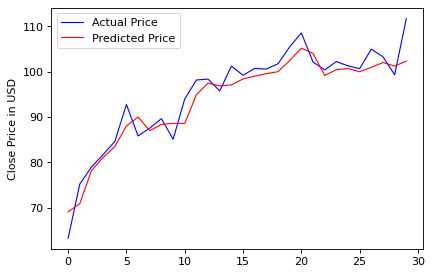

Solana


In [185]:
#SVR 
filename = '/content/drive/MyDrive/1-UIT/CS313-KTDL&UD/Đồ án/Tấn/svr_normalize_model/final/{}.joblib'.format(name_idx)

y_pred_svr, mae, mape = predict_test(filename, df_test_data, features, True)

print(name_idx)
lst_algo_3.append('SVR')
lst_mae_3.append(mae)
lst_mape_3.append(mape)
lst_name_idx_3.append(name_idx)

mean_absolute_error: 3.817968566667081
mean_absolute_percentage_error: 0.04130487197031855


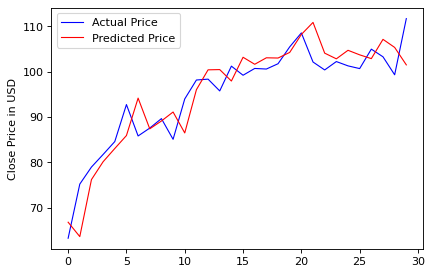

Solana


In [186]:
#Lasso
filename = '/content/drive/MyDrive/1-UIT/CS313-KTDL&UD/Đồ án/Tấn/lasso_normalize_model/{}.sav'.format(name_idx)

y_pred_lasso, mae, mape = predict_test(filename, df_test_data, features, True)
print (name_idx)
lst_algo_3.append('LassoCV')
lst_mae_3.append(mae)
lst_mape_3.append(mape)
lst_name_idx_3.append(name_idx)

mean_absolute_error: 4.228491904999008
mean_absolute_percentage_error: 0.04540278232909737


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


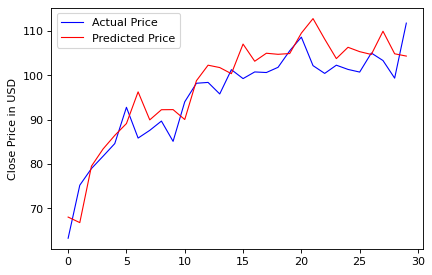

Solana


In [187]:
#Linear
filename = '/content/drive/MyDrive/1-UIT/CS313-KTDL&UD/Đồ án/Tấn/linear_normalize_model/{}.sav'.format(name_idx)

y_pred_linear, mae, mape = predict_test(filename, df_test_data, features, True)
print (name_idx)
lst_algo_3.append('Linear')
lst_mae_3.append(mae)
lst_mape_3.append(mape)
lst_name_idx_3.append(name_idx)

In [188]:
df_test_data_compare['y_pred_svr'] = y_pred_svr
df_test_data_compare['y_pred_lasso'] = y_pred_lasso
df_test_data_compare['y_pred_linear'] = y_pred_linear

df_test_data_compare.iloc[:, 7:11]

,Price_after_1_day,y_pred_svr,y_pred_lasso,y_pred_linear
0,63.27,69.108002,66.808555,68.038616
1,75.22,70.914997,63.630332,66.791932
2,78.98,78.180016,76.209101,79.510286
3,81.76,81.119049,80.154811,83.395002
4,84.60,83.483315,83.070715,86.441413
5,92.77,88.036100,85.932611,89.110285
6,85.84,90.019156,94.192098,96.252947
7,87.58,86.998415,87.416127,89.938951
8,89.67,88.398314,89.144053,92.227357
9,85.10,88.631044,91.127106,92.249768


In [189]:
record_res_3 = pd.DataFrame({'Algorithm': lst_algo_3,
                           'Data': lst_name_idx_3,
                           'MAE_3': lst_mae_3,
                           'MAPE_3': lst_mape_3})

record_res_3.set_index(['Data', 'Algorithm'])

MAE_3    MAPE_3
Data   Algorithm                    
Solana SVR        2.541206  0.027386
       LassoCV    3.817969  0.041305
       Linear     4.228492  0.045403

###So sánh

In [136]:
merged_12 = pd.merge(record_res_1, record_res_2)
res_merged = pd.merge(merged_12, record_res_3)

res_merged.set_index(['Data', 'Algorithm'])

MAE_1    MAPE_1        MAE_2    MAPE_2        MAE_3  \
Data    Algorithm                                                              
Bitcoin SVR         964.586095  0.025099    -1.000000 -1.000000  4109.451839   
        LassoCV    1001.222254  0.026183  1188.890594  0.031045   917.830775   
        Linear     1124.411115  0.029176  1105.446804  0.028713  1190.323615   

                     MAPE_3  
Data    Algorithm            
Bitcoin SVR        0.104146  
        LassoCV    0.023956  
        Linear     0.030904

In [48]:
#lưu kết quả so sánh
res_merged.to_csv('/content/drive/MyDrive/1-UIT/CS313-KTDL&UD/Đồ án/Tấn/A2_Demo/result.csv', index=False)

In [137]:
def plot_compare(ax, path, features, df_test_data, normalize=False):
    filename = '/content/drive/MyDrive/1-UIT/CS313-KTDL&UD/Đồ án/Tấn/' + path

    df_test_data = df_test_data[features]
    if normalize:
      # chuẩn hóa
      df_max = df_test_data.max()
      df_min = df_test_data.min()
      df_test_data = (df_test_data - df_min)/(df_max - df_min)

    # chia X, y
    y = df_test_data.Prediction
    X = df_test_data.iloc[:, :-1]

    # load model
    loaded_model = joblib.load(filename)
    y_pred = loaded_model.predict(X)

    if normalize:
      # Trả lại tỷ lệ ban đầu theo đơn giá USD cho cột Close
      y = y*(df_max[-1] - df_min[-1]) + df_min[-1]
      y_pred = y_pred*(df_max[-1] - df_min[-1]) + df_min[-1]

    lst_mae.append(mean_absolute_error(y, y_pred))
    lst_mape.append(mean_absolute_percentage_error(y, y_pred))

    ax.plot(y.values, label="Actual Price", color='blue', linewidth =1)
    ax.plot(y_pred.flatten(), label="Predicted Price", color='red', linewidth =1)
    ax.set_ylabel('Close Price in USD')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


,Algorithm,Data,MAE,MAPE
0,lasso(high-low-open-close),Bitcoin,1001.222254,0.026183
1,lasso(high-low-open-close-marketcap),Bitcoin,1188.890594,0.031045
2,lasso_normalize_model,Bitcoin,917.830775,0.023956
3,linear(high-low-open-close),Bitcoin,1124.411115,0.029176
4,linear(high-low-open-close-marketcap),Bitcoin,1105.446804,0.028713
5,linear_normalize_model,Bitcoin,1190.323615,0.030904


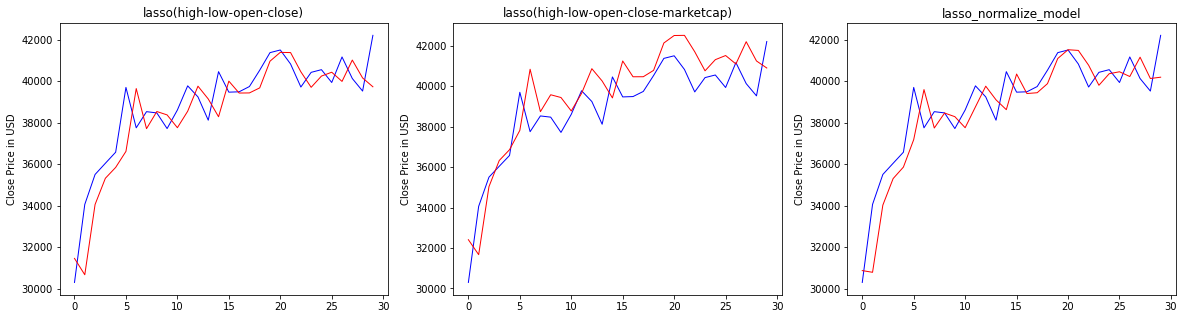

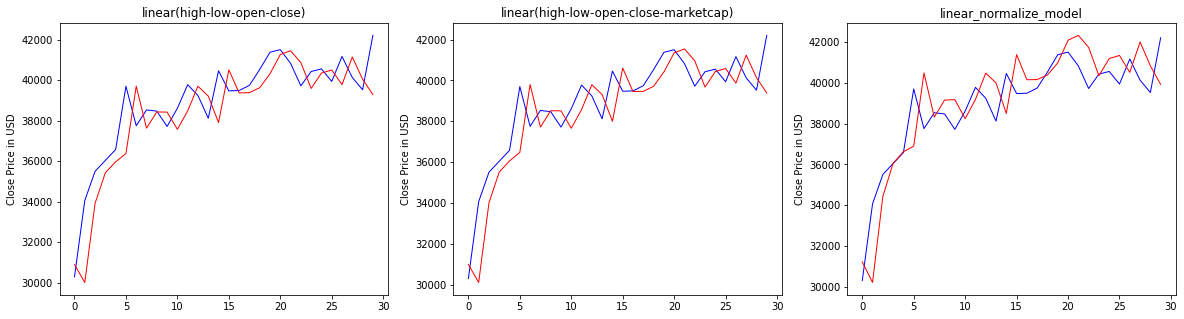

In [138]:
lst_name_algo = []
lst_name_data = []
lst_mae = []
lst_mape = []

#name_idx = 'Polkadot'
name_idx = 'Bitcoin'
#name_idx = 'Solana'

path_linear = ['linear(high-low-open-close)/{}.sav','linear(high-low-open-close-marketcap)/{}.sav', 'linear_normalize_model/{}.sav']
path_lasso = ['lasso(high-low-open-close)/{}.sav','lasso(high-low-open-close-marketcap)/{}.sav', 'lasso_normalize_model/{}.sav']
features_1 = ['High',	'Low', 'Open', 'Close', 'Prediction']
features_23 = ['High',	'Low', 'Open','Marketcap', 'Close', 'Prediction']

test_data = pd.DataFrame(data[name_idx], columns=col_name)
test_data['Prediction'] = test_data['Close'].shift(-1)
test_data = test_data.iloc[:-1]

fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=False, figsize=(20,5))
i = 0
for ax in axs.flat:
  lst_name_algo.append(path_lasso[i].replace('/{}.sav', ''))
  lst_name_data.append(name_idx)
  ax.set_title(path_lasso[i].replace('/{}.sav', ''))
  if i == 0:
    plot_compare(ax, path_lasso[i].format(name_idx), features_1, test_data)
  elif i == 1:
    plot_compare(ax, path_lasso[i].format(name_idx), features_23, test_data)
  else:
    plot_compare(ax, path_lasso[i].format(name_idx), features_23, test_data, True)
  i += 1

fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=False, figsize=(20,5))
i = 0
for ax in axs.flat:
  lst_name_algo.append(path_linear[i].replace('/{}.sav', ''))
  lst_name_data.append(name_idx)
  ax.set_title(path_linear[i].replace('/{}.sav', ''))
  if i == 0:
    plot_compare(ax, path_linear[i].format(name_idx), features_1, test_data)
  elif i == 1:
    plot_compare(ax, path_linear[i].format(name_idx), features_23, test_data)
  else:
    plot_compare(ax, path_linear[i].format(name_idx), features_23, test_data, True)
  i += 1

record_res = pd.DataFrame({'Algorithm': lst_name_algo,
                           'Data': lst_name_data,
                           'MAE': lst_mae,
                           'MAPE': lst_mape})

record_res.set_index(['Data', 'Algorithm'])
record_res
